In [77]:
"""
The code in this file is part of the instructor-provided template for Assignment-1, task-1, Fall 2021. 
"""
import pyopencl as cl
import numpy as np
import time
import pyopencl.array


class clModule:
    def __init__(self):
        """
        **Do not modify this code**
        Attributes for instance of clModule
        Includes OpenCL context, command queue, kernel code.
        """

        # Get platform and device property
        NAME = 'NVIDIA CUDA'
        platforms = cl.get_platforms()
        devs = None
        for platform in platforms:
            if platform.name == NAME:
                devs = platform.get_devices()       

        # Create Context:
        self.ctx = cl.Context(devs)

        # Setup Command Queue:
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

        # kernel - will not be provided for future assignments!
        kernel_code = """
            __kernel void sum(__global float* c, __global float* a, __global float* b, const unsigned int n)
            {
                unsigned int i = get_global_id(0);
                if (i < n) {
                    c[i] = a[i] + b[i];
                }
            }
        """ 

        # Build kernel code
        self.prg = cl.Program(self.ctx, kernel_code).build()

    def deviceAdd(self, a, b, length):
        """
        Function to perform vector addition using the cl.array class
        Arguments:
            a       :   1st Vector
            b       :   2nd Vector
            length  :   length of vectors.
        Returns:
            c       :   vector sum of arguments a and b
            time_   :   execution time for pocl function 
        """
        # start to record
        t_start = time.time()

        # device memory allocation
        a_d = cl.array.to_device(self.queue, a)
        b_d = cl.array.to_device(self.queue, b)
            # cl.array.empty_like(ary), ary needs to be in the device
        c_d = cl.array.empty_like(b_d)
        
        # execute operation.
            # need to pass a_d.data to the kernel instead of the vector it self
            # length is a python int object, the kernel expect a int32 object
        # t_start = time.time()
        self.prg.sum(self.queue, a.shape, None, c_d.data, a_d.data, b_d.data, np.int32(length))

        # wait for execution to complete.
        self.queue.finish()

        # Record execution time 
        time_ = time.time() - t_start

        # Copy output from GPU to CPU [Use .get() method]
        c = c_d.get()

        # return a tuple of output of addition and time taken to execute the operation.
        return (c, time_)


    def bufferAdd(self, a, b, length):
        """
        Function to perform vector addition using the cl.Buffer class
        Returns:
            c               :    vector sum of arguments a and b
            end - start     :    execution time for pocl function 
        """
        # Create three buffers (plans for areas of memory on the device)
            # start to record
        time_start = time.time()
            # make space in host for result
        c = np.empty(length).astype(np.float32)
            # make space for input arrays in device, and copy from host
        a_d = cl.Buffer(self.ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=a)
        b_d = cl.Buffer(self.ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=b)
            # make space for output arrays in device
        c_d = cl.Buffer(self.ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=c)

        # execute operation with numpy syntax
        self.prg.sum(self.queue, a.shape, None, a_d, b_d, c_d, np.int32(length))
        
        # Wait for execution to complete.
        self.queue.finish()

        # Record execution time 
        time_ = time.time() - time_start
        
        # Copy output from GPU to CPU [Use enqueue_copy]
        cl.enqueue_copy(self.queue, c, c_d)

        # return a tuple of output of addition and time taken to execute the operation.
        return (c, time_)


    def numpyAdd(self, a, b, length):
        """
        Function to perform vector addition on host(CPU).
        Arguments:
            a       :   1st Vector
            b       :   2nd Vector
            length  :   length of vector a or b[since they are of same length] 
        """
        a = np.array(a)
        b = np.array(b)

        start = time.time()
        c = a + b
        end = time.time()

        return c, end - start



In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

def average_time(method_name, N=1024, iteration=10):
    """
    Function to compute the average time comsumed by addtional functions
    Arguments:
        N           :   length of vectors
        iteration   :   number of iterations of one specific function
        method_name :   the name of the function
    """
    # used to record the processing time
    time = 0
    # make an instance of the clModule class
    clop = clModule()
    # using method of pyopencl.array
    if method_name == 'device':
        for i in range(iteration):
            a = np.random.rand(N).astype(np.float32)
            b = np.random.rand(N).astype(np.float32)
            _, temp = clop.deviceAdd(a,b,N)
            time += temp
        time /= iteration
        return time
    # using method of pyopencl.Buffer
    elif method_name == 'numpy':
        for i in range(iteration):
            a = np.random.rand(N).astype(np.float32)
            b = np.random.rand(N).astype(np.float32)
            _, temp = clop.numpyAdd(a,b,N)
            time += temp
        time /= iteration
        return time
    # using numpy in the host
    elif method_name == 'buffer':
        for i in range(iteration):
            a = np.random.rand(N).astype(np.float32)
            b = np.random.rand(N).astype(np.float32)
            _, temp = clop.bufferAdd(a,b,N)
            time +=temp
        time /= iteration
        return time
    else:
        print('No such method name!')


if __name__ == "__main__":
    # Define the number of iterations and starting lengths of vectors
    N = 1000000
    iteration = 1
    # a = np.random.rand(N).astype(np.float32)
    # b = np.random.rand(N).astype(np.float32)
    # print(a,b)


    # Create an instance of the clModule class
    # clop = clModule()
    # c = clop.deviceAdd(a,b,N)
    # print(c)

    # Perform addition tests for increasing lengths of vectors
    # L = 10, 100, 1000 ..., (You can use np.random.randn to generate two vectors)
    L = []
    for i in range(8): L.append(10**(i+1))
    time_array = []
    time_buffer = []
    time_numpy = []
    for l in L:
        time_array.append(1000*average_time('device', N=l, iteration=iteration))
        time_buffer.append(1000*average_time('buffer', N=l, iteration=iteration))
        time_numpy.append(1000*average_time('numpy', N=l, iteration=iteration))





    # Compare outputs.

    # Plot the compute times

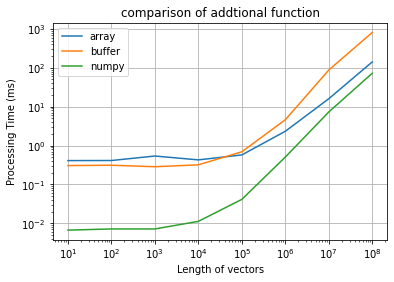

In [118]:
def plotting(time_array, time_buffer, time_numpy, L):
    plt.figure()
    plt.plot(L,time_array,label='array')
    plt.plot(L,time_buffer,label='buffer')
    plt.plot(L,time_numpy,label='numpy')
    plt.semilogx()
    plt.semilogy()
    plt.legend()
    plt.grid()
    plt.xlabel('Length of vectors')
    plt.ylabel('Processing Time (ms)')
    plt.title('comparison of addtional function')
    plt.show()


plotting(time_array, time_buffer, time_numpy, L)

In [113]:
for i in range(7): print(i+1)


1
2
3
4
5
6
7
